In [1]:
#hide
%reload_ext autoreload
%autoreload 2

import importlib
import alphaquant
importlib.reload(alphaquant)

<module 'alphaquant' from '/Users/constantin/workspace/alphaquant/alphaquant/__init__.py'>

In [2]:
import os

os.chdir("../../../test_data/system_tests/proteoforms/mann_labs_egfr")

In [3]:

EGFR_PROTEINS = "QuickGO-annotations-1689586252205-20230717.tsv"
SAMPLEMAP_FILE = "samplemap_egfr_100ng.tsv"
RESULTS_DIR = "results_minrep5_fewclusterfilt"
RESULTS_DIR = "results"
PROTEIN_ID_MAPPING = "protein_mapping.tsv"
PHOSPHO_PREDLIB = "../phospho_predlib/human_uniprot_reviewed_phos_prob.tsv"


CONDPAIRS = [("untreated", "egf_treated")]
CONDPAIR = CONDPAIRS[0]


In [4]:
import pandas as pd

UNIPROT2ENTREZ = pd.read_csv(PROTEIN_ID_MAPPING, sep = "\t")
UNIPROT2ENTREZ = UNIPROT2ENTREZ.dropna()
UNIPROT2SYMBOL = dict(zip(UNIPROT2ENTREZ["uniprot"], UNIPROT2ENTREZ["symbol"]))
UNIPROT2ENTREZ = UNIPROT2ENTREZ.dropna(subset=['entrez'])


UNIPROT2ENTREZ["entrez"] = UNIPROT2ENTREZ["entrez"].astype(int)
UNIPROT2ENTREZ = dict(zip(UNIPROT2ENTREZ["uniprot"], UNIPROT2ENTREZ["entrez"]))

In [5]:
import pandas as pd

df_phospho_predlib = pd.read_csv(PHOSPHO_PREDLIB, sep='\t')
df_phospho_predlib["sequence"] = [f"SEQ_{x}_" for x in df_phospho_predlib["sequence"]]
SEQUENCE2PROB = dict(zip(df_phospho_predlib["sequence"], df_phospho_predlib["ptm_prob"]))
predicted_phosphoprone_sequences = set(df_phospho_predlib[df_phospho_predlib['ptm_prob'] >= 0.5]["sequence"])

count    2.549733e+06
mean    -6.018580e+00
std      2.232917e+00
min     -7.648091e+00
25%     -7.179219e+00
50%     -7.046351e+00
75%     -6.384852e+00
max      0.000000e+00
Name: ptm_prob, dtype: float64


<AxesSubplot:>

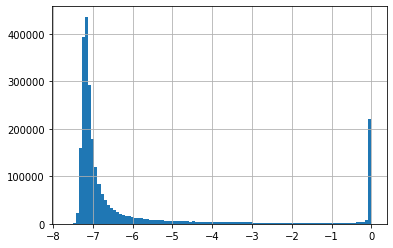

In [7]:
import numpy as np

log_probs = np.log10(df_phospho_predlib["ptm_prob"])
print(log_probs.describe())
#plot histogram of log probabilities
log_probs.hist(bins=100)

In [ ]:
import alphaquant.diffquant_utils as aqutils

condpairtree_proteome = aqutils.read_condpair_tree(cond1=CONDPAIR[0], cond2=CONDPAIR[1], results_folder=RESULTS_DIR)
#condpairtree_ptm = aqutils.read_condpair_tree(cond1=condpair[0], cond2=condpair[1], results_folder=results_dir_phospho)


In [ ]:
import alphaquant.visualizations as aqplot
import alphaquant.outlier_scoring as aqoutlier



outlier_handler = aqoutlier.OutlierHandler(results_dir = RESULTS_DIR, cond1 = CONDPAIR[0], cond2 = CONDPAIR[1])
clusterdiffinfos_list = outlier_handler.get_diffclust_overview_list()
#clusterdiffinfos_list = [x for x in clusterdiffinfos_list if x.name in predicted_phosphoprone_sequences]

In [ ]:
import numpy as np

def assign_phosphoprone_scores(clusterdiffinfo_list, sequence2prob):
	for clusterdiff_info in clusterdiffinfo_list:
		clusterdiff_info.phosphoprone_score = 0
		phosphoprone_scores = []
		for outlier_peptide_name in clusterdiff_info.outlier_peptide_names:
			phosphoprone_scores.append(sequence2prob.get(outlier_peptide_name, 0))
		clusterdiff_info.phosphoprone_score = np.min(phosphoprone_scores)

assign_phosphoprone_scores(clusterdiffinfos_list, SEQUENCE2PROB)


In [ ]:
#clusterdiffinfos_list = [x for x in clusterdiffinfos_list if x.name in predicted_phosphoprone_sequences]
clusterdiffinfos_list_filtered = [x for x in clusterdiffinfos_list if len(x.outlier_peptide_names) < 3]
print(len(clusterdiffinfos_list_filtered))
clusterdiffinfos_list_filtered = [x for x in clusterdiffinfos_list_filtered if x.outlier_peptide_names[0] in predicted_phosphoprone_sequences]
print(len(clusterdiffinfos_list_filtered))


4303
894


In [ ]:
import pandas as pd
def get_fcdiffs_df(list_of_clusterdiffinfos):
    df_dict = {}
    df_dict["protein_id"] = []
    df_dict["fcdiff"] = []
    df_dict["cluster_size"] = []
    df_dict["phosphoprone_score"] = []

    for clusterdiffinfo in list_of_clusterdiffinfos:
        df_dict["protein_id"].append(clusterdiffinfo.protein_name)
        df_dict["fcdiff"].append(clusterdiffinfo.fcdiff)
        df_dict["cluster_size"].append(len(clusterdiffinfo.outlier_peptide_names))
        df_dict["phosphoprone_score"].append(clusterdiffinfo.phosphoprone_score)

    
    return pd.DataFrame(df_dict)


#fcdiffs_df = get_fcdiffs_df(clusterdiffinfos_list_filtered)
fcdiffs_df = get_fcdiffs_df(clusterdiffinfos_list)

fcdiffs_df = fcdiffs_df.sort_values(by=["fcdiff"])
display(fcdiffs_df)
#fcdiffs_df_maxdiff = fcdiffs_df.drop_duplicates(subset = ['protein_id'],keep='last')


,protein_id,fcdiff,cluster_size,phosphoprone_score
5767,O43715,0.000097,2,5.380764e-08
703,P49591;Q5T5C7,0.000112,3,5.883836e-08
5861,O00116,0.000409,2,2.335117e-06
2037,Q15029;Q15029-2,0.000438,4,7.435326e-08
2128,O95602,0.000555,4,5.841857e-08
...,...,...,...,...
4052,Q9UK76,4.303513,1,9.999999e-01
6660,Q8WXH0;Q8WXH0-2,4.388187,1,1.133903e-07
534,P27797,4.562939,1,9.999996e-01
4160,Q86TC9,5.123070,1,3.118566e-02


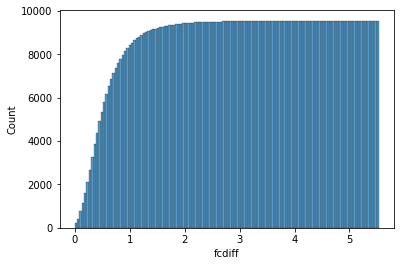

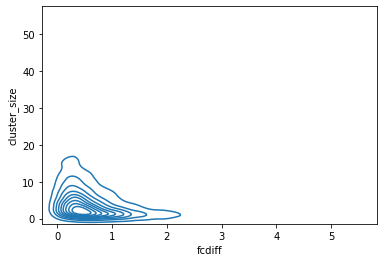

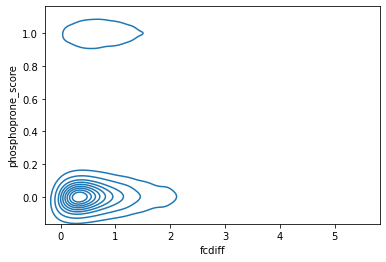

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=fcdiffs_df, x = "fcdiff",cumulative=True)
plt.show()

sns.kdeplot(data=fcdiffs_df, x = "fcdiff", y = "cluster_size")
plt.show()

sns.kdeplot(data=fcdiffs_df, x = "fcdiff", y = "phosphoprone_score")
plt.show()



In [ ]:
import easygo.go_runner as go_runner

#get all protein ids with fcdiff larger than 0.75
fcdiff_threshold = 1
phosphoprone_threshold = 0.7
protein_ids_outlier = fcdiffs_df[(fcdiffs_df["fcdiff"]> fcdiff_threshold) & (fcdiffs_df["cluster_size"] < np.inf) & (fcdiffs_df["phosphoprone_score"] > phosphoprone_threshold)]["protein_id"]
protein_ids_outlier = [id for protein in protein_ids_outlier for id in protein.split(";")]

print(len(protein_ids_outlier))

NameError: name 'fcdiffs_df' is not defined

In [ ]:
all_protein_ids = [x.name for x in condpairtree_proteome.children]
all_protein_ids = [id for protein in all_protein_ids for id in protein.split(";")]


background_ids_entrez = [UNIPROT2ENTREZ.get(id) for id in all_protein_ids if id in UNIPROT2ENTREZ.keys()]

In [173]:
egfr_proteins_df = pd.read_csv(EGFR_PROTEINS, sep = "\t")
display(egfr_proteins_df)
egfr_ids_entrez = [UNIPROT2ENTREZ.get(id) for id in egfr_proteins_df["GENE PRODUCT ID"] if id in UNIPROT2ENTREZ.keys()]
print(len(set(egfr_ids_entrez)))
egfr_gene_symbols = set(egfr_proteins_df["SYMBOL"])

,GENE PRODUCT DB,GENE PRODUCT ID,SYMBOL,QUALIFIER,GO TERM,GO NAME,ECO ID,GO EVIDENCE CODE,REFERENCE,WITH/FROM,TAXON ID,ASSIGNED BY,ANNOTATION EXTENSION,GO ASPECT
0,UniProtKB,A0A024R0W7,PRICKLE1,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000265,IEA,GO_REF:0000107,UniProtKB:Q3U5C7|ensembl:ENSMUSP00000104878,9606,Ensembl,NaN,P
1,UniProtKB,A0A024R8E2,ABL1,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000265,IEA,GO_REF:0000107,UniProtKB:P00520|ensembl:ENSMUSP00000075167,9606,Ensembl,NaN,P
2,UniProtKB,A0A024RC65,hCG_1991735,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000265,IEA,GO_REF:0000107,UniProtKB:Q9JKF1|ensembl:ENSMUSP00000128278,9606,Ensembl,NaN,P
3,UniProtKB,A0A0S2Z437,BTC,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000265,IEA,GO_REF:0000107,UniProtKB:A0A8I6AQ55|ensembl:ENSRNOP00000095979,9606,Ensembl,NaN,P
4,UniProtKB,A0A0S2Z437,BTC,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000265,IEA,GO_REF:0000107,UniProtKB:Q05928|ensembl:ENSMUSP00000112765,9606,Ensembl,NaN,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,UniProtKB,Q9P212,PLCE1,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000315,IMP,PMID:29058690,NaN,9606,UniProt,NaN,P
125,UniProtKB,Q9P212,PLCE1,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000303,NAS,PMID:11022048,NaN,9606,UniProt,NaN,P
126,UniProtKB,Q9P2Z9,c-erbB proto-oncogene,involved_in,GO:0007173,epidermal growth factor receptor signaling pat...,ECO:0000364,IEA,GO_REF:0000108,GO:0005006,9606,GOC,NaN,P
127,UniProtKB,Q9P2Z9,c-erbB proto-oncogene,enables,GO:0005006,epidermal growth factor receptor activity,ECO:0000303,NAS,PMID:1678600,NaN,9606,UniProt,NaN,F


18


In [174]:
#convert protein to entrez gene ids

target_ids_entrez = [UNIPROT2ENTREZ.get(id) for id in protein_ids_outlier if id in UNIPROT2ENTREZ.keys()]

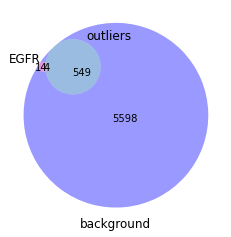

In [175]:
import matplotlib_venn as venn


res = venn.venn3([set(egfr_ids_entrez), set(target_ids_entrez), set(background_ids_entrez)], ["EGFR", "outliers", "background"])

In [176]:
import easygo.go_runner as go_runner

enrich_results = go_runner.run_go_enrichment_analysis(target_ids_entrez, background_ids_entrez, taxids=[9606], fdr_threshold=0.05)
display(enrich_results)
enrich_results.to_csv("/tmp/go_results.tsv", sep="\t")

  EXISTS: /Users/constantin/workspace/easygo/easygo/data/go-basic.obo
/Users/constantin/workspace/easygo/easygo/data/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms
  EXISTS: /Users/constantin/workspace/easygo/easygo/data/gene2go
HMS:0:00:03.918935 339,369 annotations, 20,700 genes, 18,988 GOs, 1 taxids READ: /Users/constantin/workspace/easygo/easygo/data/gene2go 

Load BP Ontology Enrichment Analysis ...
 94%  5,904 of  6,262 population items found in association

Load CC Ontology Enrichment Analysis ...
 97%  6,082 of  6,262 population items found in association

Load MF Ontology Enrichment Analysis ...
 97%  6,056 of  6,262 population items found in association

Runing BP Ontology Analysis: current study set of 612 IDs.
 95%    526 of    553 study items found in association
 90%    553 of    612 study items found in population(6262)
Calculating 8,412 uncorrected p-values using fisher_scipy_stats
   8,412 terms are associated with  5,813 of  6,262 population items
   2,547 terms 

INFO:biothings.client:querying 1-1000...


   2,996 terms are associated with  5,961 of  6,262 population items
     708 terms are associated with    544 of    553 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
     515 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-2571...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,GO,name,namespace,p_uncorrected,p_fdr_bh,study_count,study_n,pop_count,pop_n,genes,gene_symbols
0,GO:0000398,"mRNA splicing, via spliceosome",biological_process,2.058851e-06,1.074496e-02,33,553,157,6262,"[9733, 26121, 56339, 6426, 23451, 6427, 6430, ...","[SART3, PRPF31, METTL3, SRSF1, SF3B1, SRSF2, S..."
1,GO:0031396,regulation of protein ubiquitination,biological_process,3.826256e-06,1.074496e-02,7,553,10,6262,"[7046, 3304, 1616, 54165, 3320, 29979, 3326]","[TGFBR1, HSPA1B, DAXX, DCUN1D1, HSP90AA1, UBQL..."
2,GO:0002218,activation of innate immune response,biological_process,3.832010e-06,1.074496e-02,10,553,21,6262,"[10432, 7520, 3428, 4841, 3146, 2547, 6421, 97...","[RBM14, XRCC5, IFI16, NONO, HMGB1, XRCC6, SFPQ..."
3,GO:0002181,cytoplasmic translation,biological_process,5.408750e-06,1.137460e-02,21,553,82,6262,"[6146, 6154, 6156, 6157, 6160, 6161, 6173, 618...","[RPL22, RPL26, RPL30, RPL27A, RPL31, RPL32, RP..."
4,GO:0098761,cellular response to interleukin-7,biological_process,9.721402e-06,1.635529e-02,7,553,11,6262,"[4904, 2923, 10963, 471, 506, 3068, 1399]","[YBX1, PDIA3, STIP1, ATIC, ATP5F1B, HDGF, CRKL]"
5,GO:0006397,mRNA processing,biological_process,2.010036e-05,2.818070e-02,27,553,128,6262,"[51202, 5511, 51593, 56339, 6421, 6426, 6427, ...","[DDX47, PPP1R8, SRRT, METTL3, SFPQ, SRSF1, SRS..."
6,GO:1990904,ribonucleoprotein complex,cellular_component,4.348186e-12,6.309219e-09,36,553,115,6262,"[6146, 7431, 51593, 6154, 143, 26528, 10146, 2...","[RPL22, VIM, SRRT, RPL26, PARP4, DAZAP1, G3BP1..."
7,GO:0005925,focal adhesion,cellular_component,2.999017e-10,2.175787e-07,58,553,277,6262,"[6146, 9351, 7431, 6156, 6160, 126353, 51474, ...","[RPL22, NHERF2, VIM, RPL30, RPL31, MISP, LIMA1..."
8,GO:0005737,cytoplasm,cellular_component,9.085539e-10,4.394373e-07,251,553,2089,6262,"[6146, 9733, 7175, 23560, 6154, 2060, 6156, 61...","[RPL22, SART3, TPR, GTPBP4, RPL26, EPS15, RPL3..."
9,GO:0070062,extracellular exosome,cellular_component,3.500005e-09,1.269627e-06,150,553,1096,6262,"[6146, 2050, 6154, 6156, 9230, 51727, 6160, 10...","[RPL22, EPHB4, RPL26, RPL30, RAB11B, CMPK1, RP..."


In [122]:
filtered_protnodes = [x for x in condpairtree_proteome.children if x.name.split(";")[0] in protein_ids_outlier]
print(len(filtered_protnodes))

186


In [123]:
# import alphaquant.outlier_scoring as aqoutlier

# dcfilt = aqoutlier.DiffClusterFilterer(clusterdiffinfos_list, aqoutlier.DiffClusterFilterConfig(fcdiff_quantile=1, quality_score_quantile=1, num_mainclust_peptides_quantile=1,num_outlierclust_peptides_quantile=1).filterconfigs)


# filtlist = dcfilt.get_filtered_diffclust_list()
# print(len(filtlist))

In [124]:

quantification_info = aqplot.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS_DIR, samplemap=SAMPLEMAP_FILE)
pepdf_getter = aqplot.PeptideIntensityDataframeGetter(quantification_info=quantification_info)


In [125]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
%reload_ext autoreload

In [129]:
print(egfr_gene_symbols)

{'GRB2', 'IQGAP1', 'NCK2', 'EPGN', 'KIF16B', 'GAREM1', 'c-erbB proto-oncogene', 'AKT1', 'FAM83A', 'B4DL10', 'EGF', 'PIK3CA', 'ERBB4', 'SHC3', 'PLCE1', 'PLCG1', 'PIGR', 'EREG', 'PDPK1', 'EFEMP1', 'GAB1', 'BRAF', 'RASSF2', 'SHC1', 'ERBB2', 'CAMLG', 'HBEGF', 'PRICKLE1', 'BCAR1', 'SOX9', 'EGFR', 'REPS2', 'PIK3C2A', 'TGFB1', 'PTK2B', 'ERBIN', 'TDGF1', 'SOS1', 'ABL1', 'GRB7', 'AREG', 'NPR2', 'VIL1', 'SLC30A10', 'BTC', 'PTK2', 'FAM83B', 'FAM83C', 'TGFA', 'PTPN11', 'SOCS5', 'hCG_1991735', 'SRC'}


BCAR1


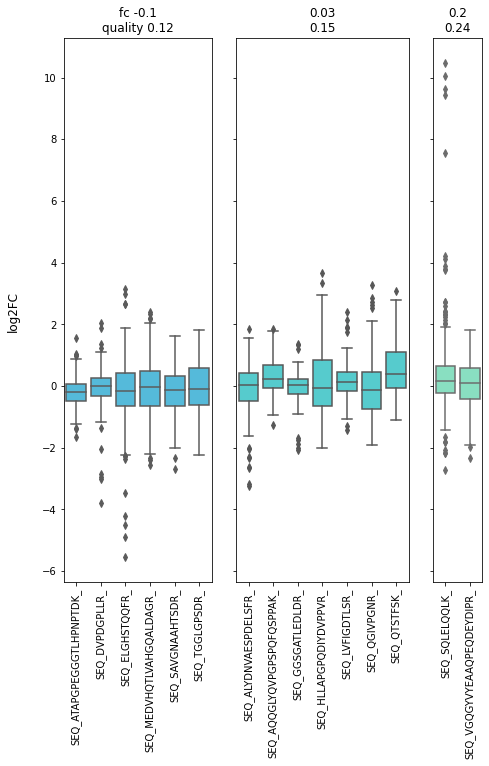

MAPK14


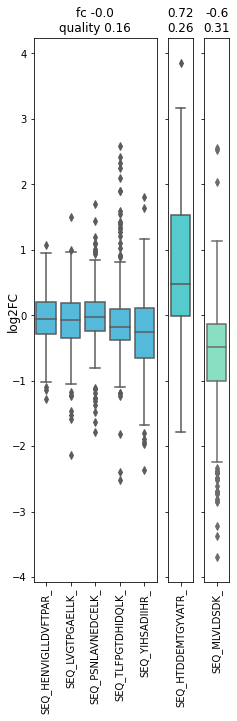

EGFR


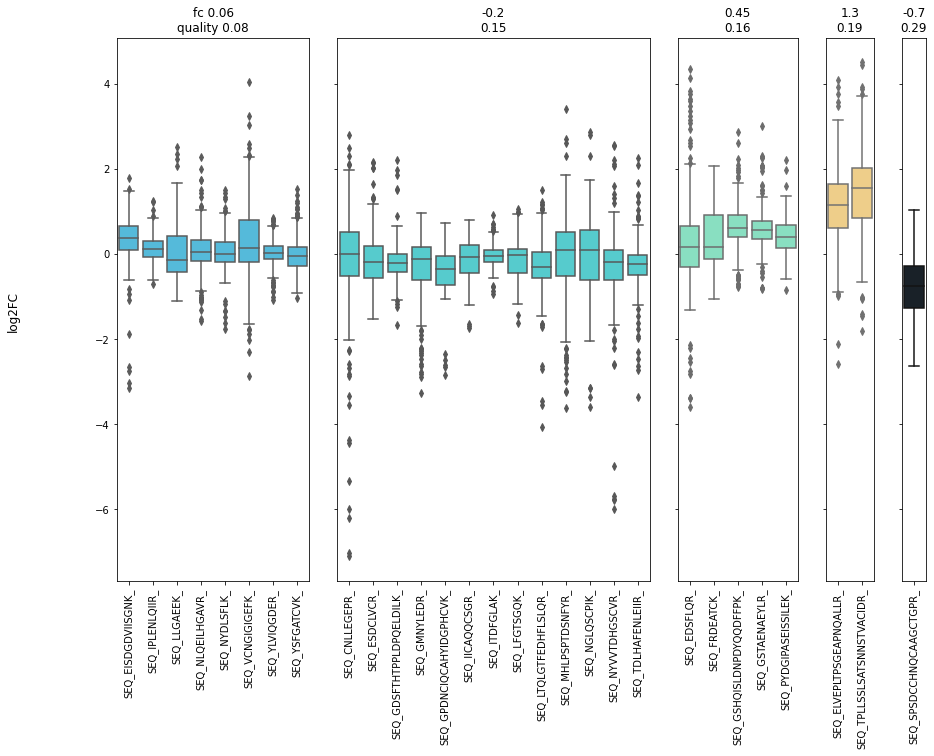

PTK2


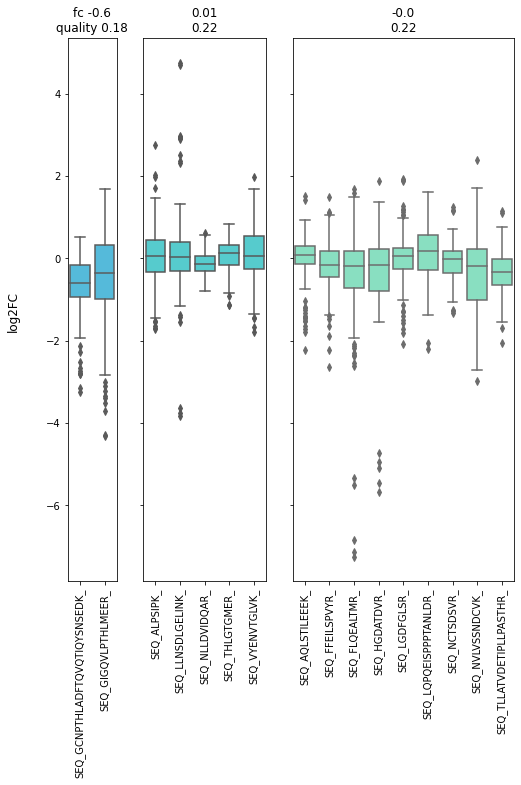

IQGAP1


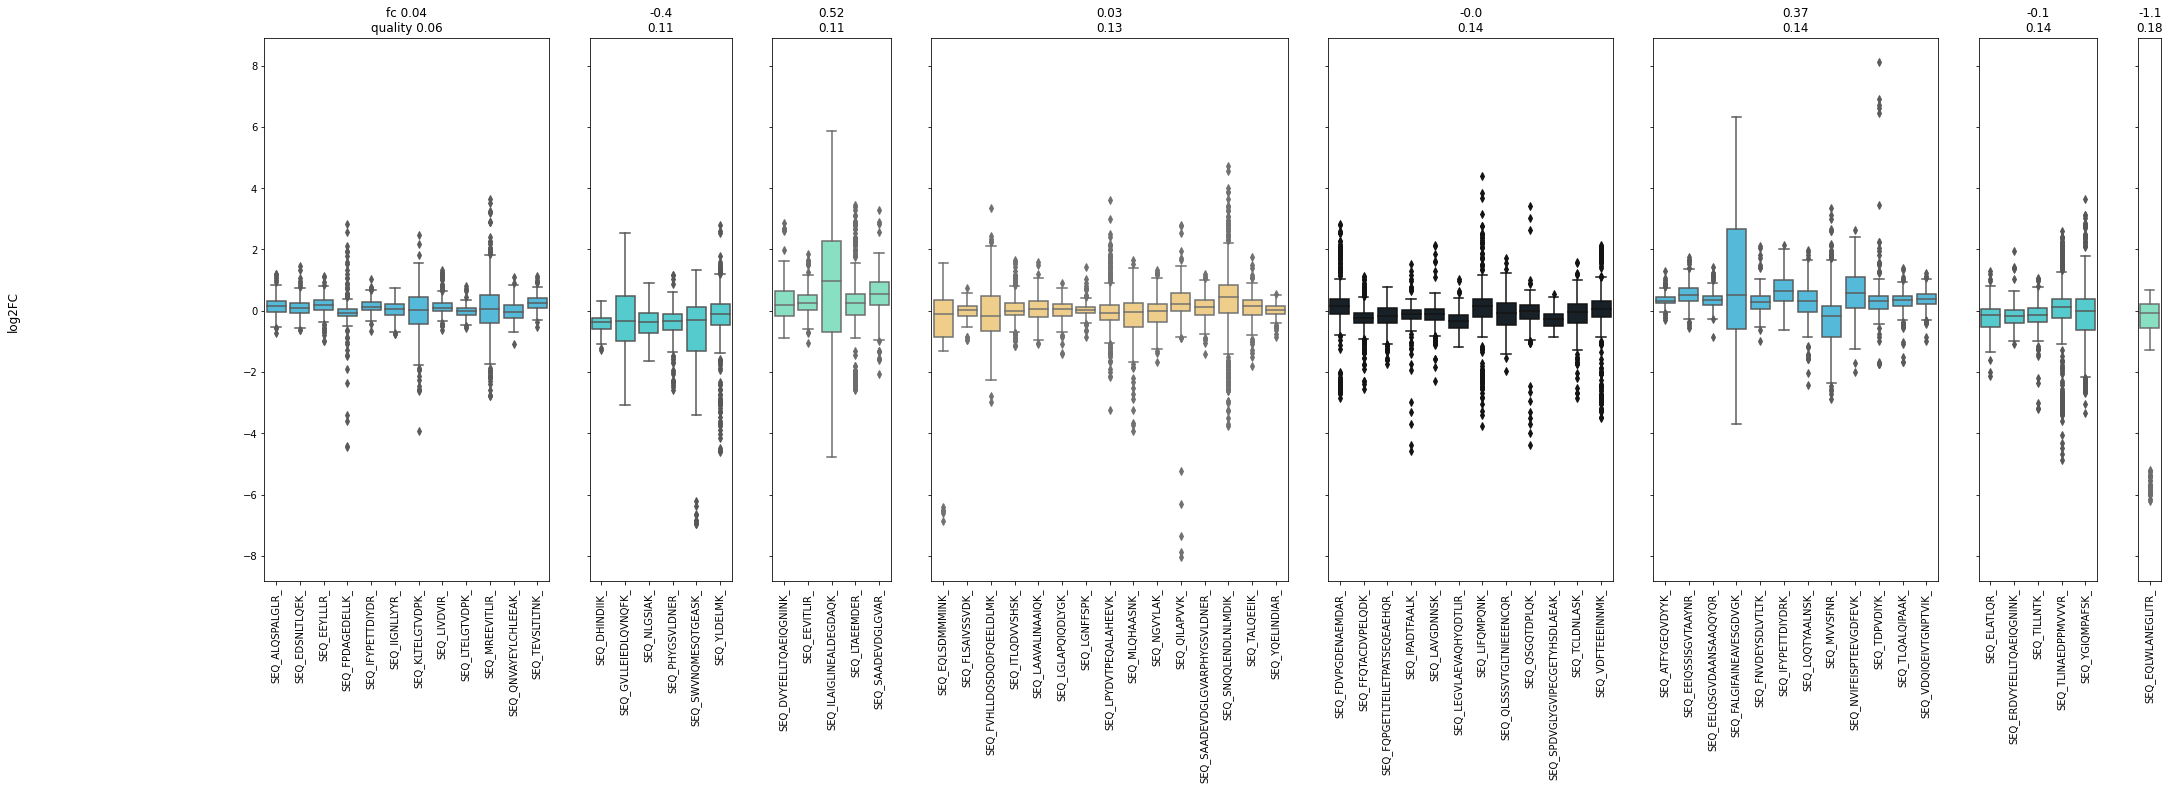

MAPK1


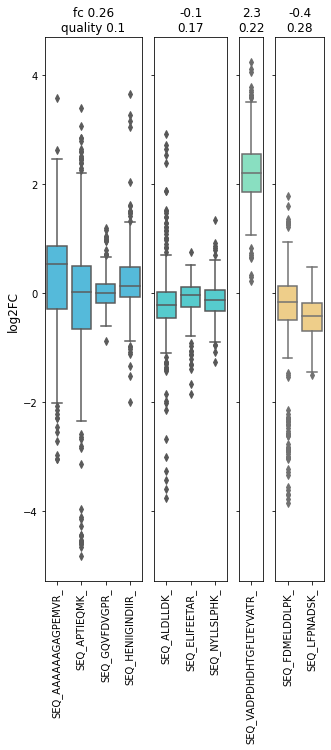

PTPN11


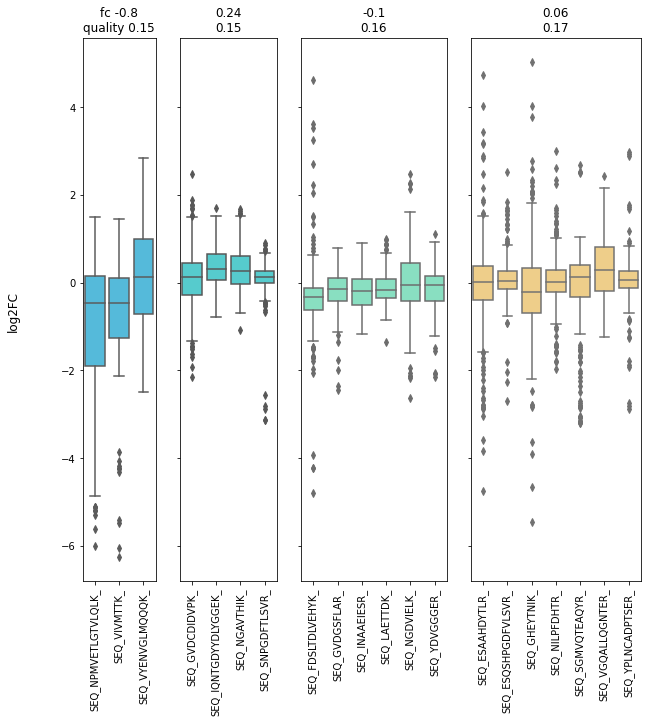

PLCG1


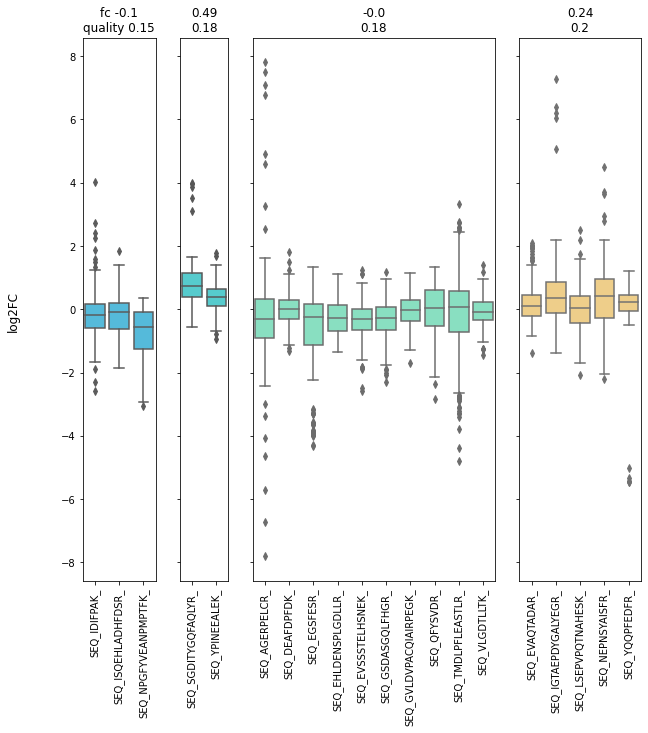

PIK3C2A


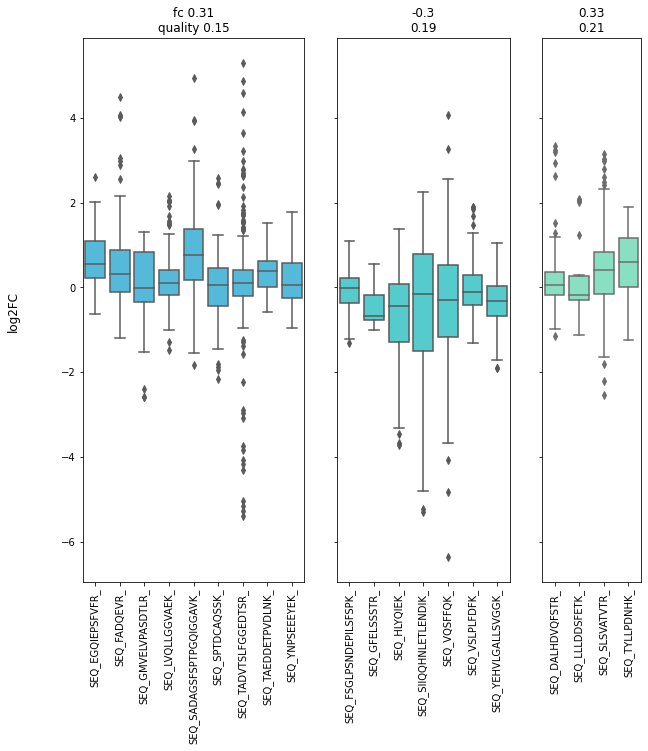

AKT1


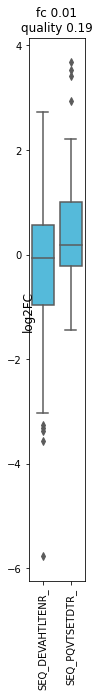

MAPKAPK2


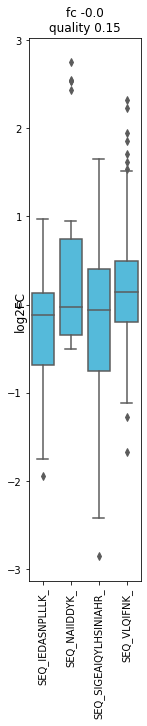

SHC1


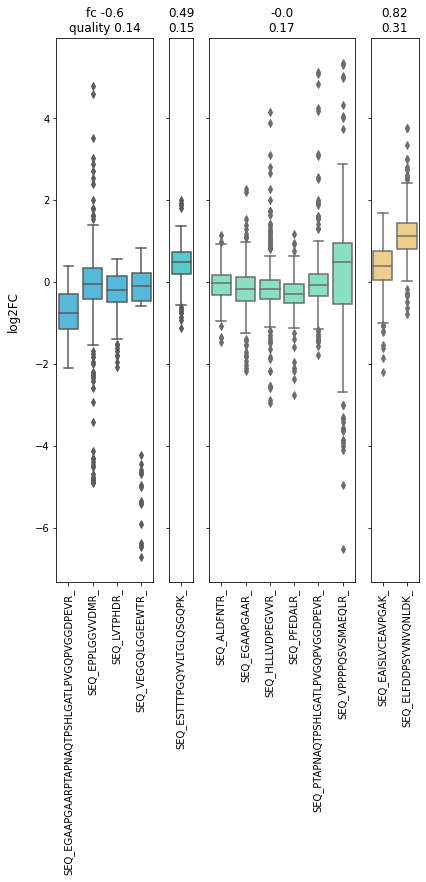

MAPK8


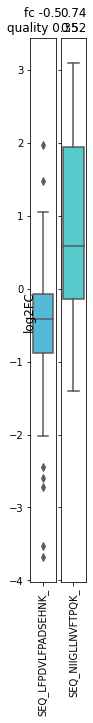

ERBIN


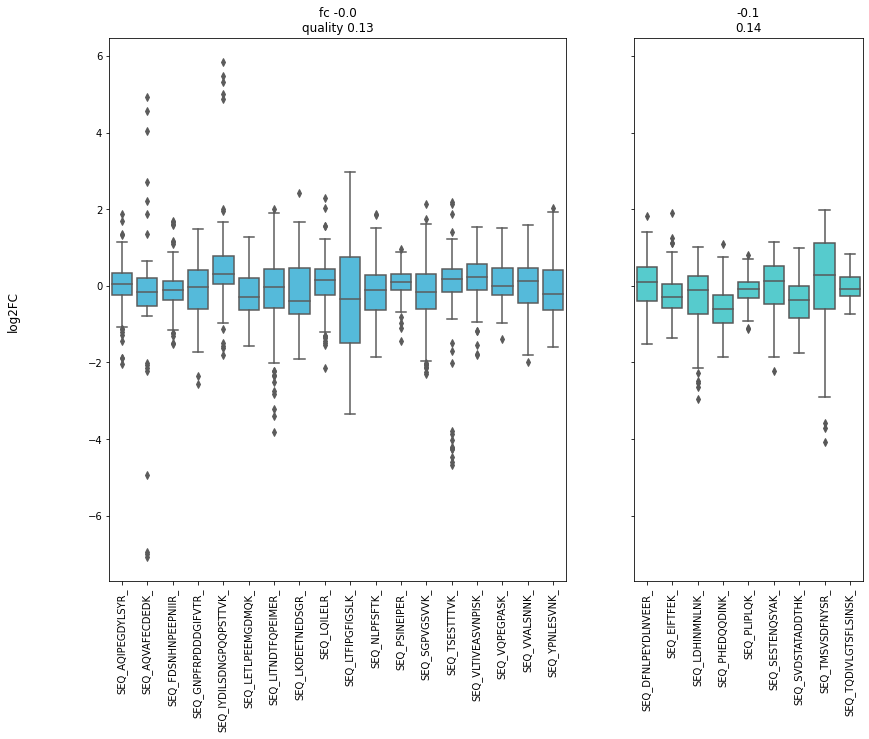

GAB1


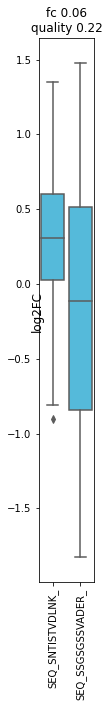

FAM83B


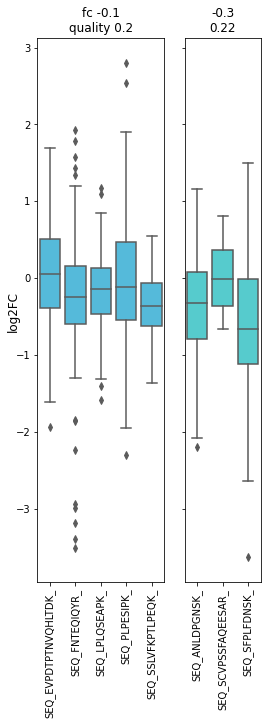

MAPK3


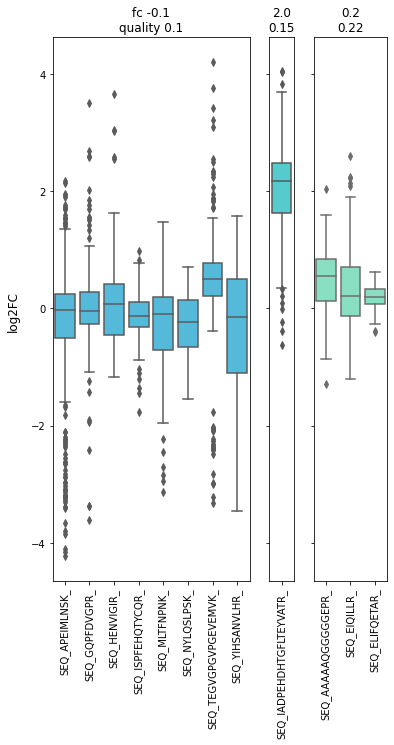

MAPK1IP1L


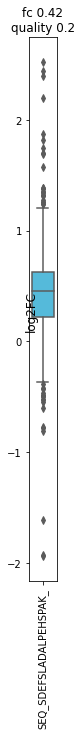

GRB2


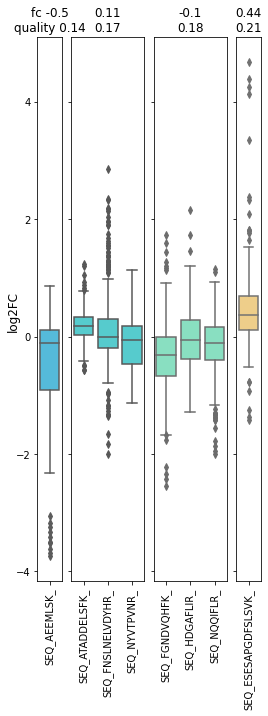

PDPK1


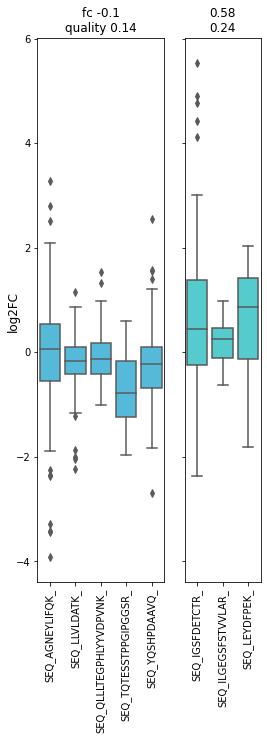

ABL1


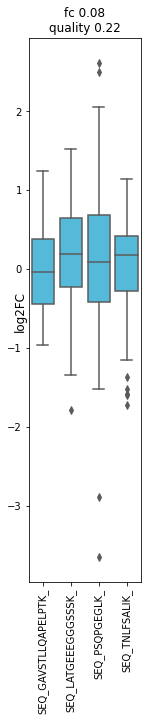

MAPK9


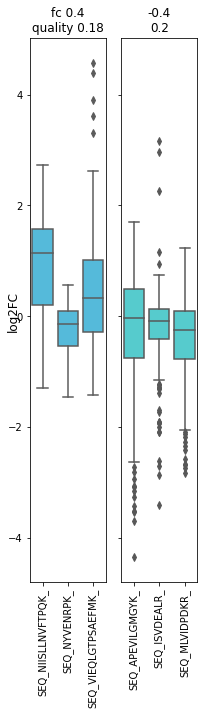

SOS1


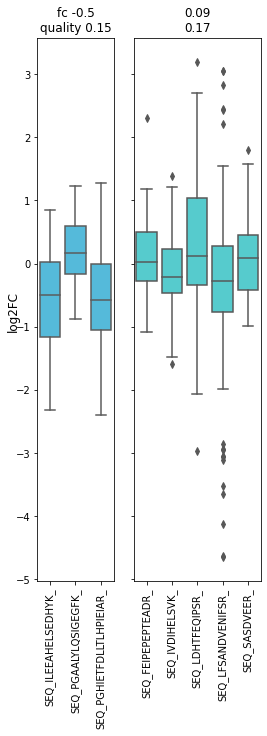

REPS2


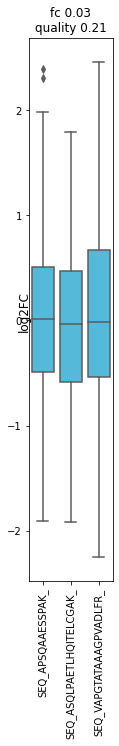

MAPKAPK3


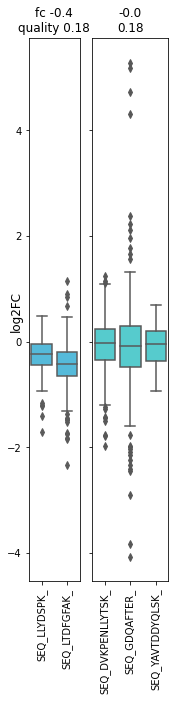

EFEMP1


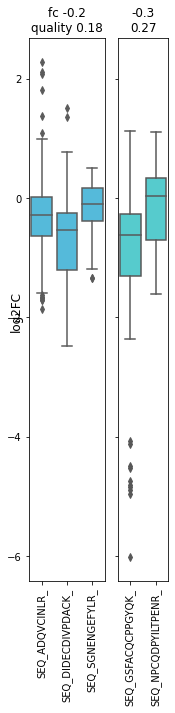

MAPK11


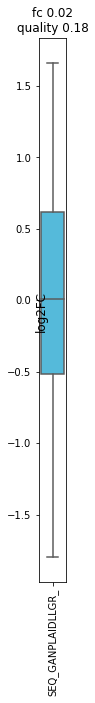

BRAF


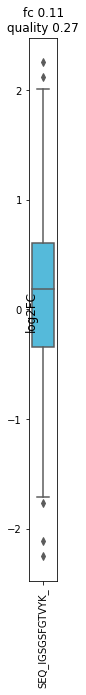

PIK3CA


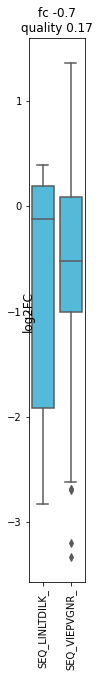

ERBB2


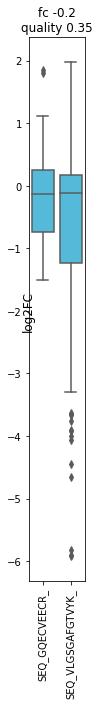

MAPKAP1


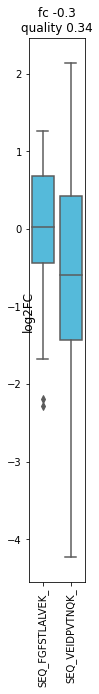

In [133]:
egfr_gene_symbols.add("MAPK1")
egfr_gene_symbols.add("MAPK14")
egfr_gene_symbols.add("MAPK9")
egfr_gene_symbols.add("MAPK8")
for protnode in condpairtree_proteome.children:
    gene_symbol = UNIPROT2SYMBOL.get(str(protnode.name).split(";")[0], "")
    #add elements to set

    if gene_symbol in egfr_gene_symbols or "MAPK" in gene_symbol:
        print(gene_symbol)
        pcplotter = aqplot.ProteinClusterPlotter(protnode,CONDPAIR, pepdf_getter)
        pcplotter.plot_all_clusters_for_protein()

In [67]:
if True:
    import mygene

    def create_mapping_df(uniprot_ids):
        mg = mygene.MyGeneInfo()
        output = mg.querymany(uniprot_ids, scopes='uniprot', fields=['entrezgene', 'symbol'], species='human')
        
        # create a list of dictionaries to initialize pandas DataFrame
        data = []
        for record in output:
            data.append({
                'uniprot': record['query'], 
                'entrez': record.get('entrezgene', None), 
                'symbol': record.get('symbol', None)
            })
        

            
        return pd.DataFrame(data)

    uniprot_ids = [x.name.split(";")[0] for x in condpairtree_proteome.children]
    mapping_df = create_mapping_df(uniprot_ids)
    mapping_df.to_csv("protein_mapping.tsv", sep="\t", index=None)


INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-6829...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


SEQ_AIGGIILTASHNPGGPNGDFGIK_
outlier fc 0.1680905643618495
modified fc 0.5166003778998194


outlier protnormed 0.25207058896603884
modified protnormed 0.6005804025040087


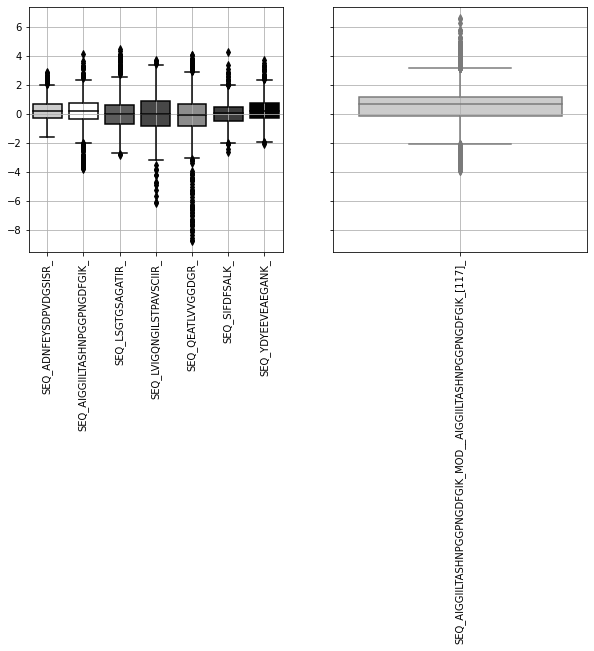

SEQ_PVSSAASVYAGAGGSGSR_
outlier fc 0.27733498718075206
modified fc 1.531487294108624


outlier protnormed -0.6061033233635242
modified protnormed 0.6480489835643476


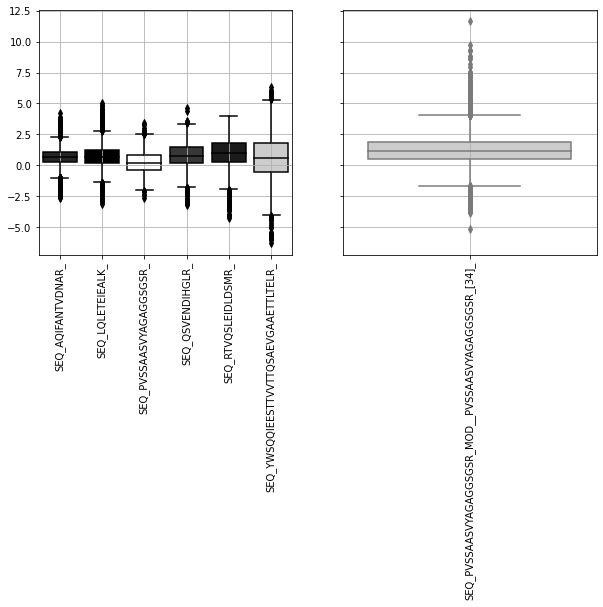

SEQ_EEPSQNDISPK_
outlier fc 0.5920376660145926
modified fc -3.074045533075278


outlier protnormed 1.5996579177232686
modified protnormed -2.066425281366602


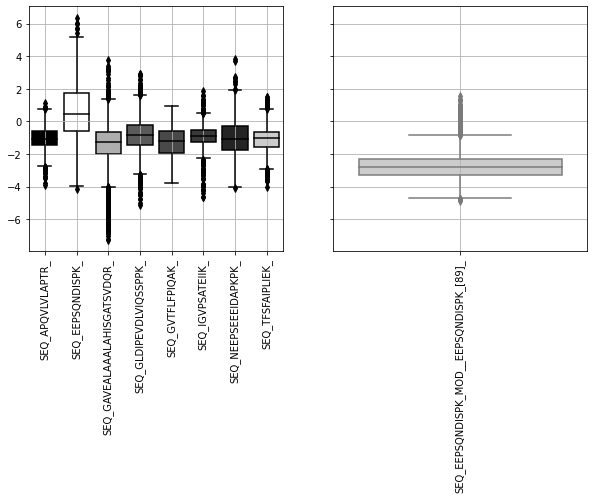

SEQ_MQEAMTQEVSDVFSDTTTPIK_
outlier fc -0.006688072437703335
modified fc -0.5982525101249816


outlier protnormed -0.5556154739894597
modified protnormed -1.147179911676738


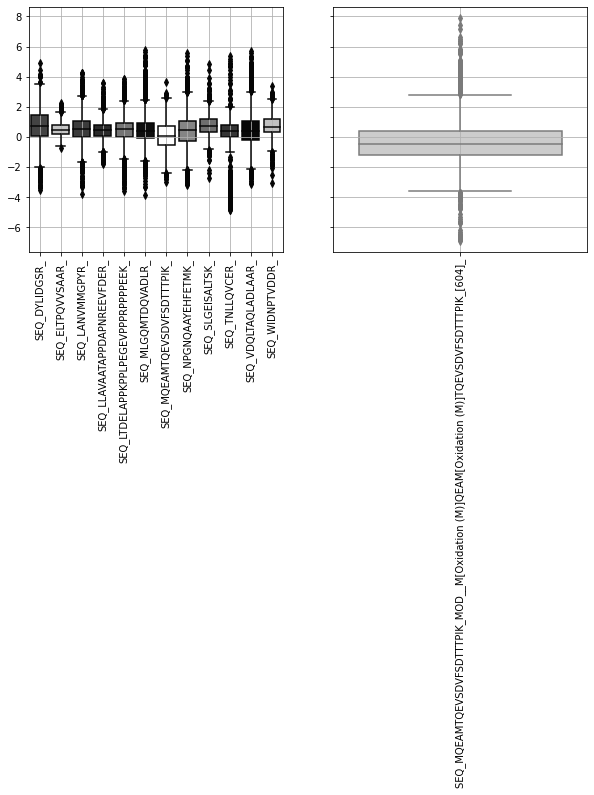

SEQ_SPSDSGYSYETIGK_
outlier fc 1.0690656972028294
modified fc -0.014861272210682286


outlier protnormed -0.027749964548998918
modified protnormed -1.1116769339625105


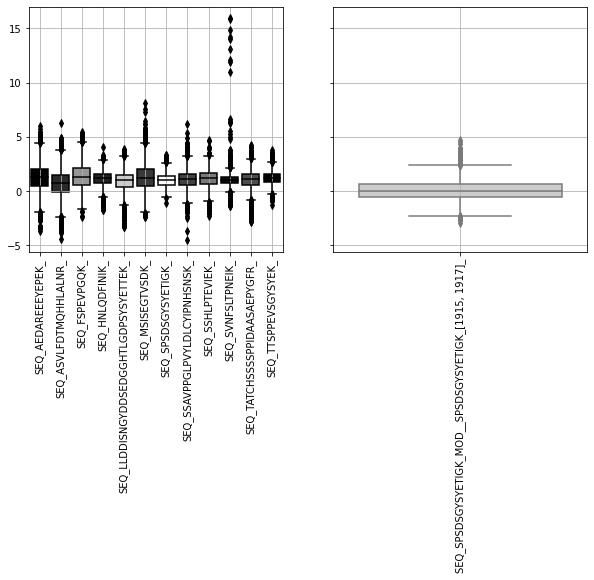

SEQ_ISMSEVDLNVAAPK_
outlier fc 0.49810658873220337
modified fc 1.719596349549095


outlier protnormed -0.4054278764235226
modified protnormed 0.8160618843933689


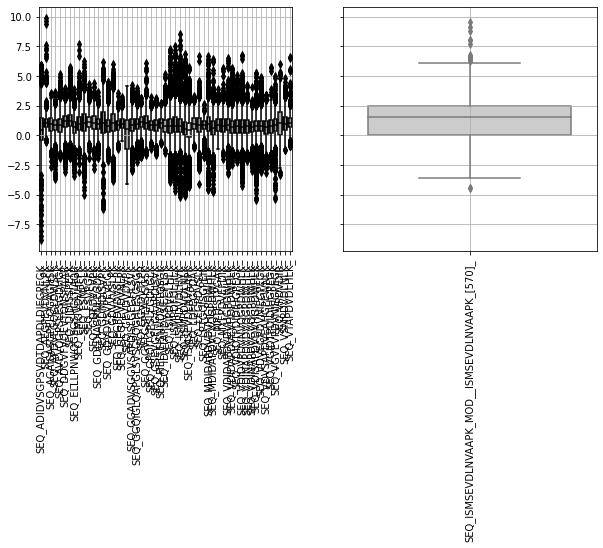

SEQ_SRAEAESMYQIK_
outlier fc 1.1440806076487502
modified fc 0.8923148859573533


outlier protnormed 0.231453925717525
modified protnormed -0.020311795973871893


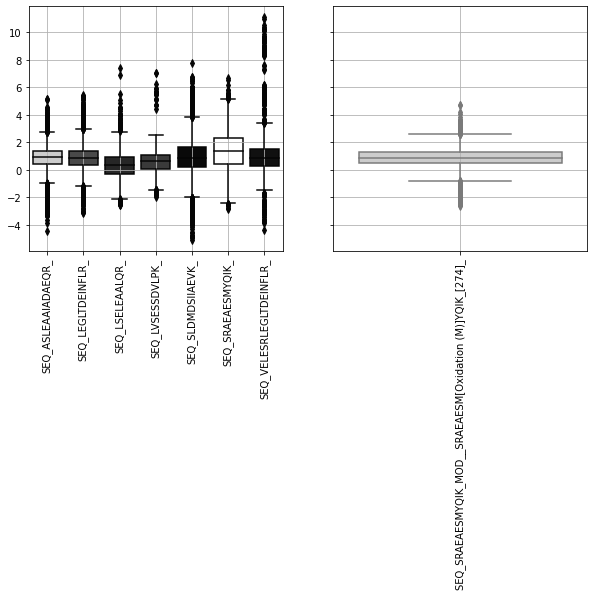

SEQ_TSPSSPAPLPHQEATPR_
outlier fc 0.962065347650278
modified fc 1.246767304211314


outlier protnormed 0.8262294346019254
modified protnormed 1.1109313911629617


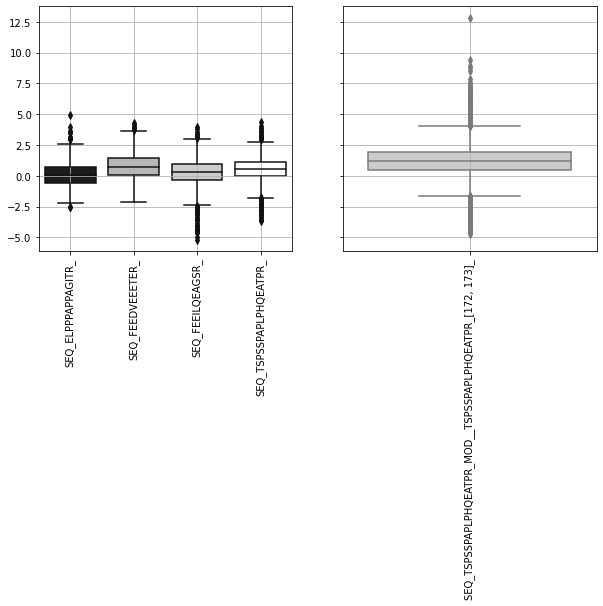

SEQ_HIDCAHVYQNENEVGVAIQEK_
outlier fc 1.5819458037274936
modified fc -0.004639393655431576


outlier protnormed 0.16613771610283345
modified protnormed -1.4204474812800918


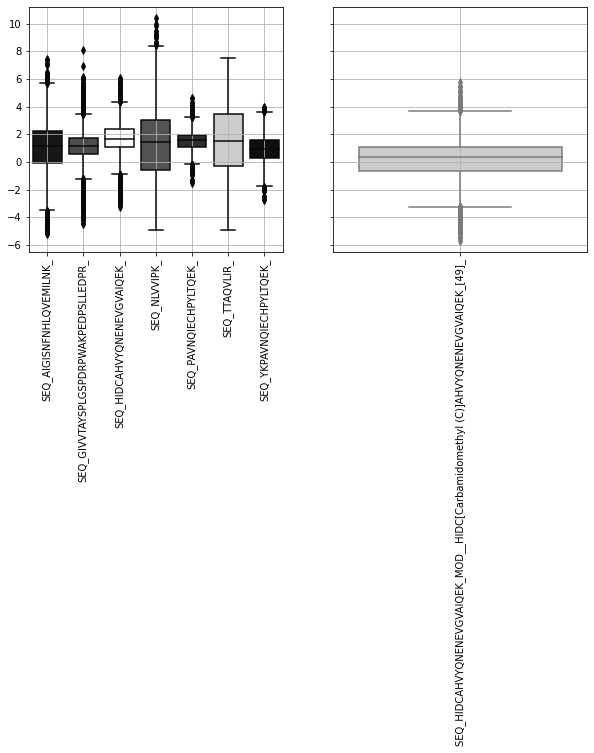

SEQ_ATVVVEATEPEPSGSIANPAASTSPSLSHR_
outlier fc 1.842548586135406
modified fc 0.10152524530296497


outlier protnormed 0.7457329243835777
modified protnormed -0.9952904164488634


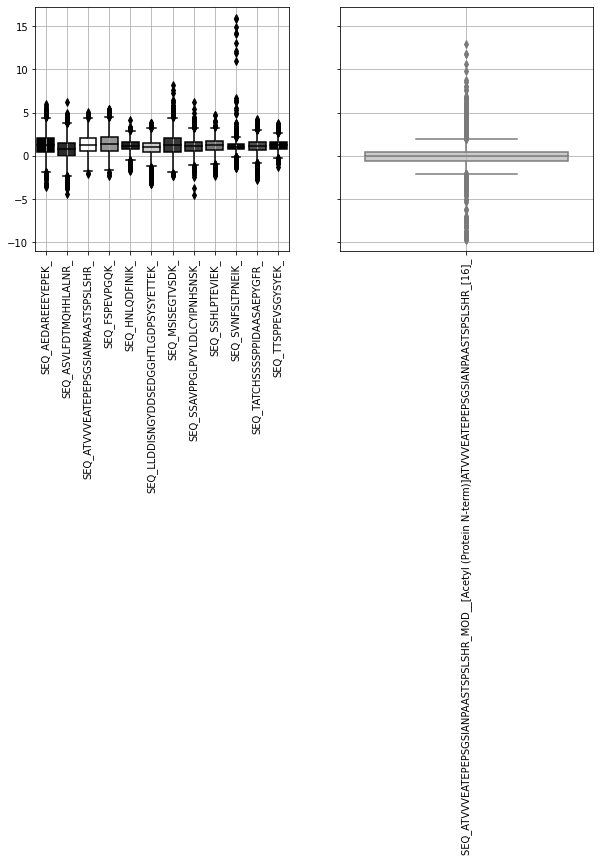

SEQ_SSLGSHQLPR_
outlier fc 0.852189974136957
modified fc 0.2655485281252301


outlier protnormed -0.20638414564152852
modified protnormed -0.7930255916532554


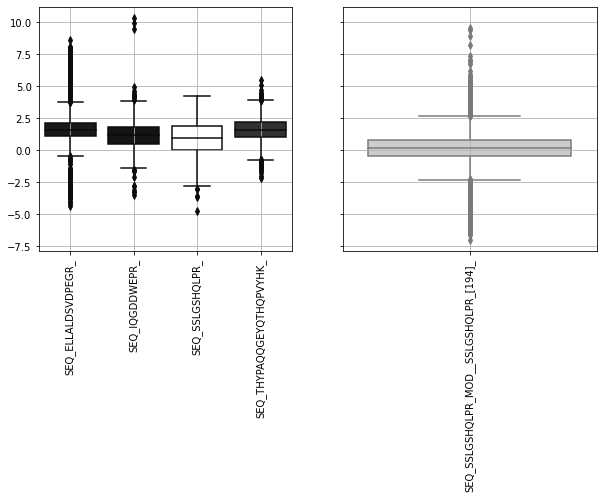

SEQ_GIVVTAYSPLGSPDRPWAK_
outlier fc 0.7370048815131696
modified fc 1.2988801308952076


outlier protnormed -0.6788032061114906
modified protnormed -0.11692795672945255


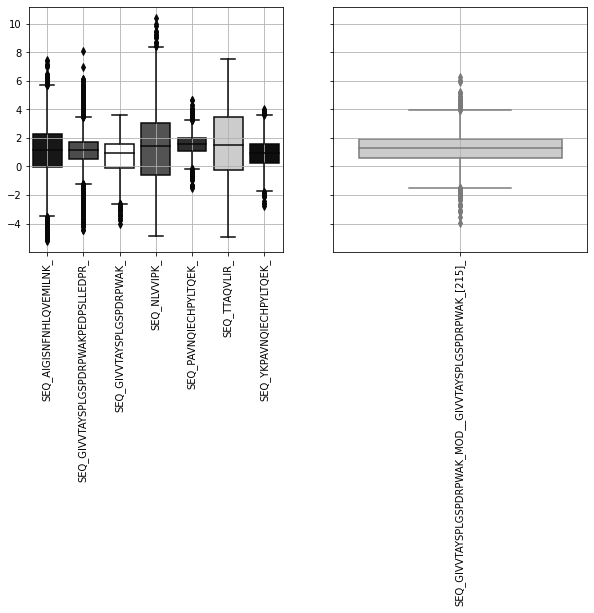

SEQ_VEAPSLDVHMDSPDINIEGPDVK_
outlier fc 0.6083838405428845
modified fc -0.02683226452359698


outlier protnormed -0.2951506246128415
modified protnormed -0.930366729679323


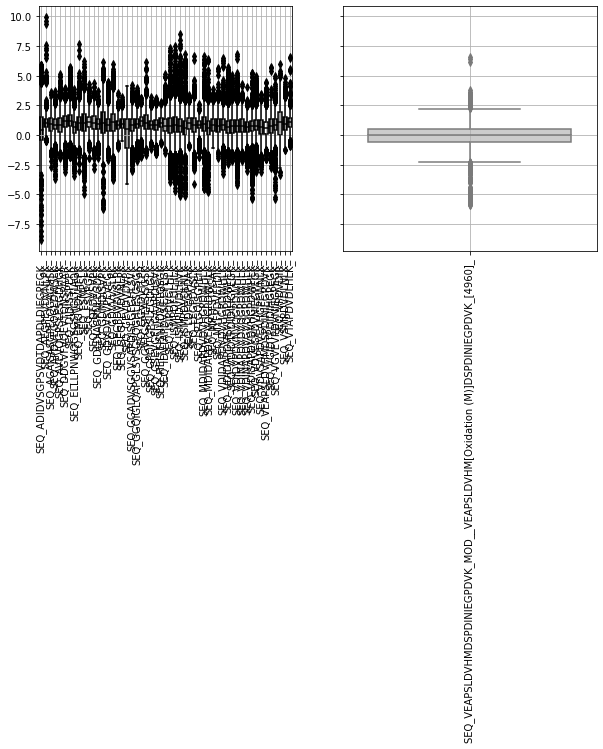

SEQ_SQSPAASDCSSSSSSASLPSSGR_
outlier fc 0.9394104406663301
modified fc 1.139809925543919


outlier protnormed -0.11916367911215542
modified protnormed 0.08123580576543343


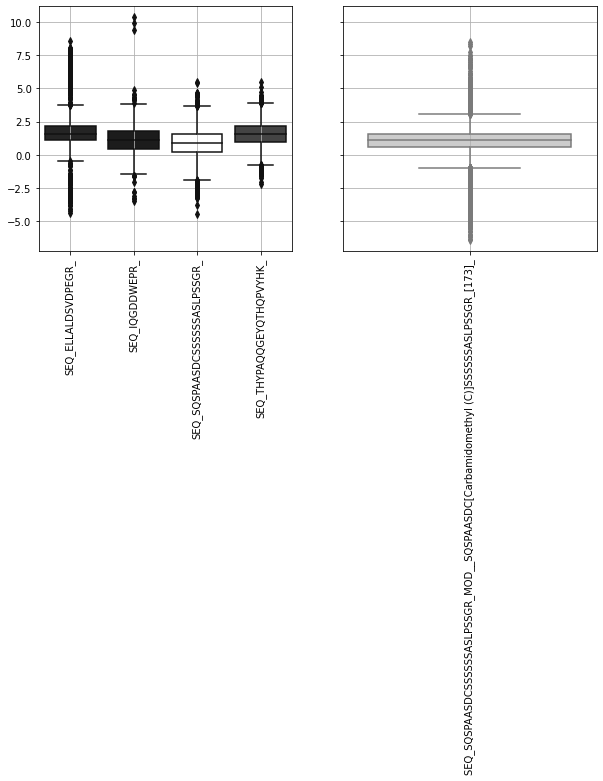

SEQ_LPSEGPRPAHVVVGDVLQAADVDK_
outlier fc 1.0276266151421685
modified fc 1.0443292720818107


outlier protnormed 0.4621738281180763
modified protnormed 0.4788764850577185


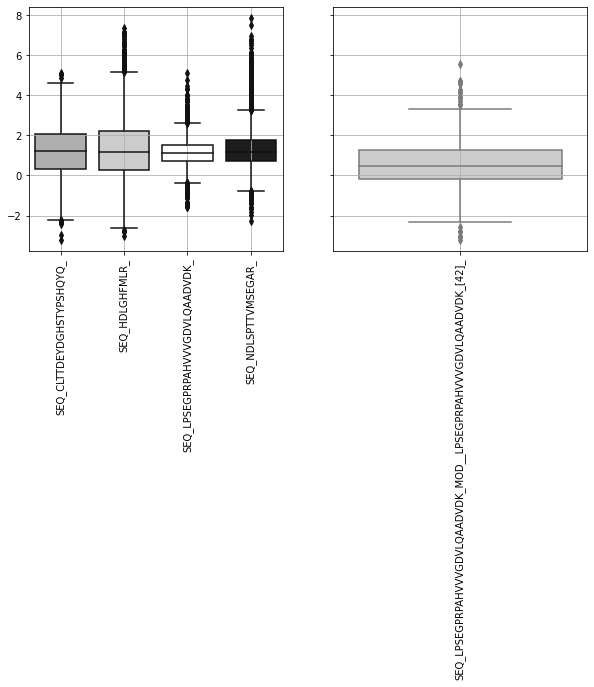

SEQ_GDQPAASGDSDDDEPPPLPR_
outlier fc -0.003863797085631518
modified fc 0.724677740433719


outlier protnormed -0.6106725729858927
modified protnormed 0.11786896453345785


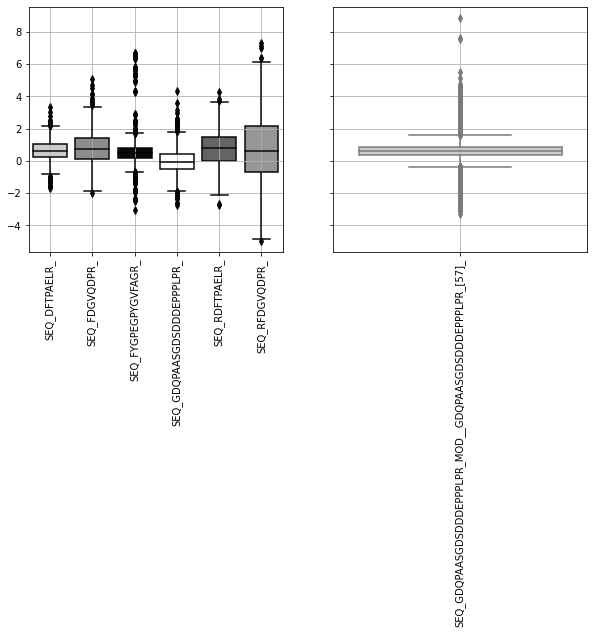

SEQ_ANEPTHFTVDCTEAGEGDVSVGIK_
outlier fc 0.7399321378473644
modified fc 0.19317889622576814


outlier protnormed -0.07745078810769113
modified protnormed -0.6242040297292875


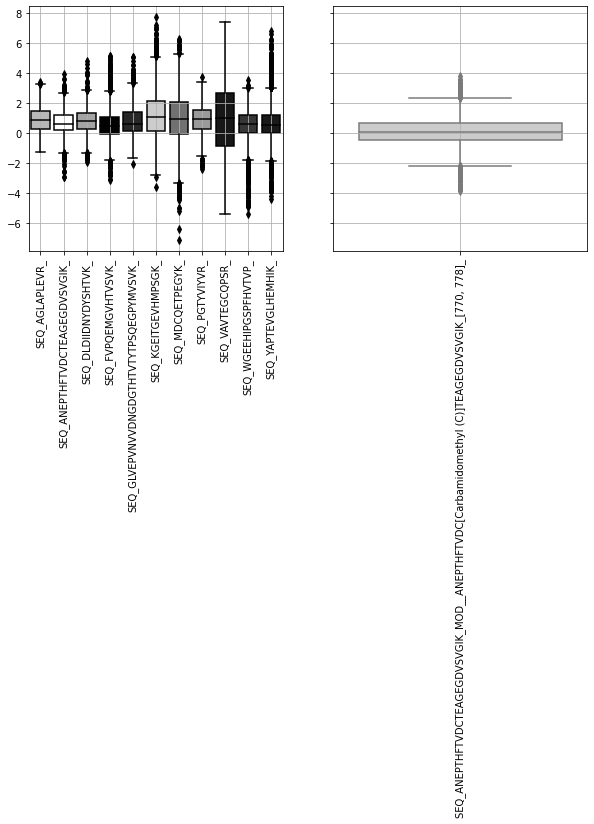

SEQ_TLVSTVGSMVFNEGEAQR_
outlier fc 0.753604299219907
modified fc 1.1194820905697564


outlier protnormed 0.2598379846601401
modified protnormed 0.6257157760099895


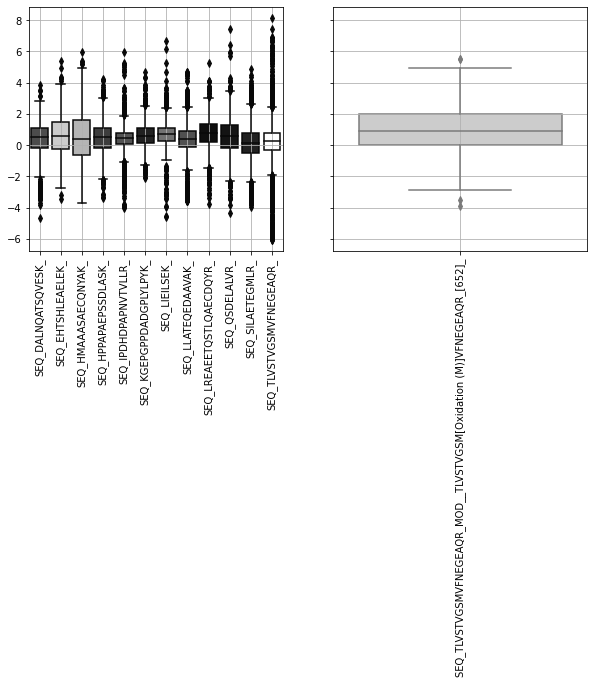

SEQ_EEMQSNVEVVHTYR_
outlier fc 0.35963823393870986
modified fc 0.7370863243594852


outlier protnormed -0.08122875194881846
modified protnormed 0.29621933847195686


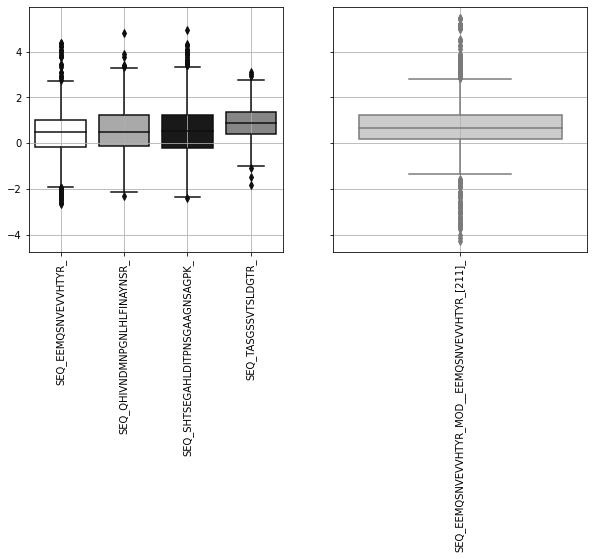

SEQ_SEDGVEGDLGETQSR_
outlier fc 0.2025683995841496
modified fc 1.7384467977926548


outlier protnormed -0.7009660655715764
modified protnormed 0.8349123326369288


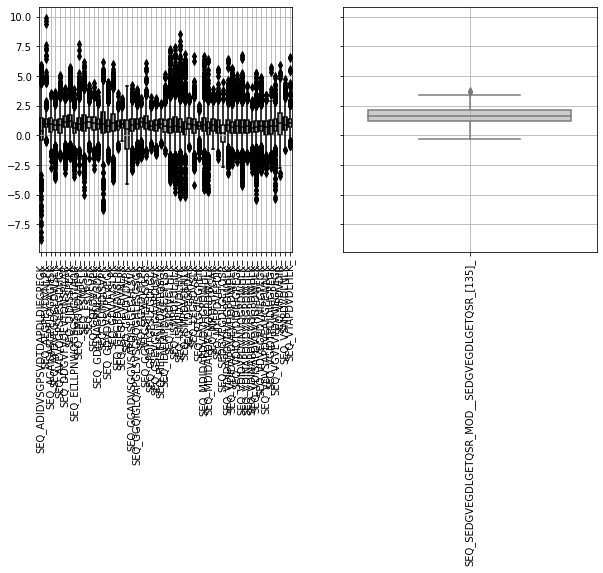

SEQ_QFTPCQLLADHANSPNK_
outlier fc 0.7663975518023085
modified fc -0.5338432664068192


outlier protnormed 0.17134118063011206
modified protnormed -1.1288996375790157


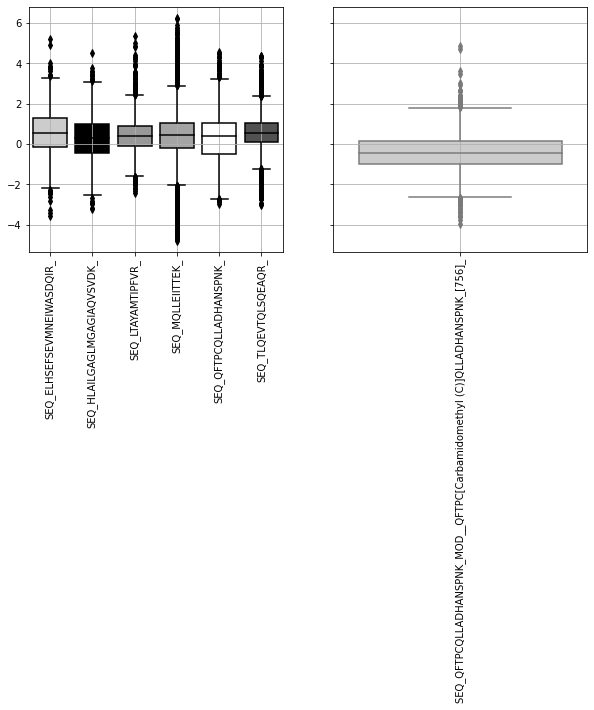

SEQ_AGSNMLLIGVHGPTTPCEEVSMK_
outlier fc 0.8963705416733385
modified fc 1.4355480472613662


outlier protnormed 0.07898761571828294
modified protnormed 0.6181651213063106


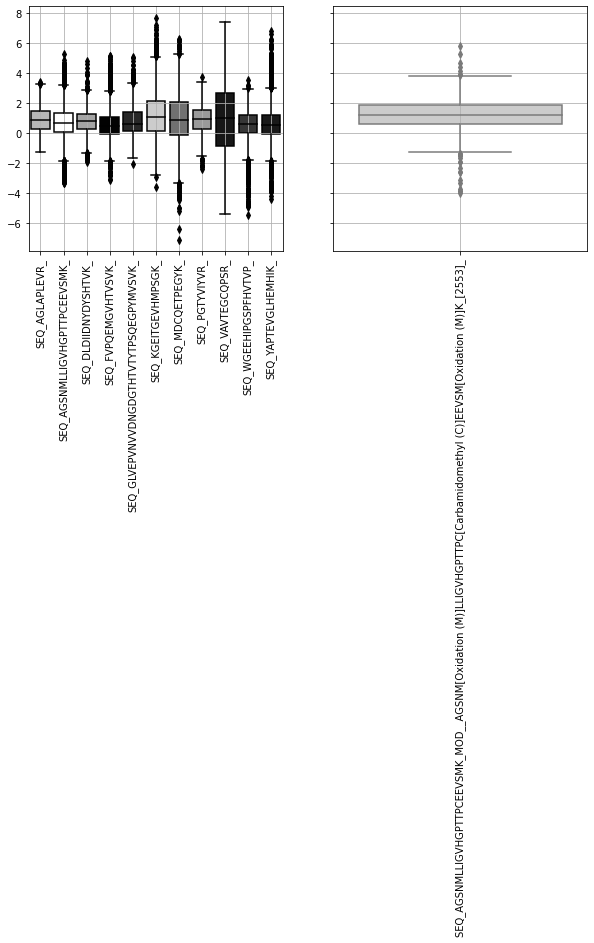

SEQ_TSPADHGGSVGSESGGSAVDSVAGEHSVSGR_
outlier fc 0.04195131688281477
modified fc 0.09137795059198428


outlier protnormed -0.14614281925601763
modified protnormed -0.0967161855468481


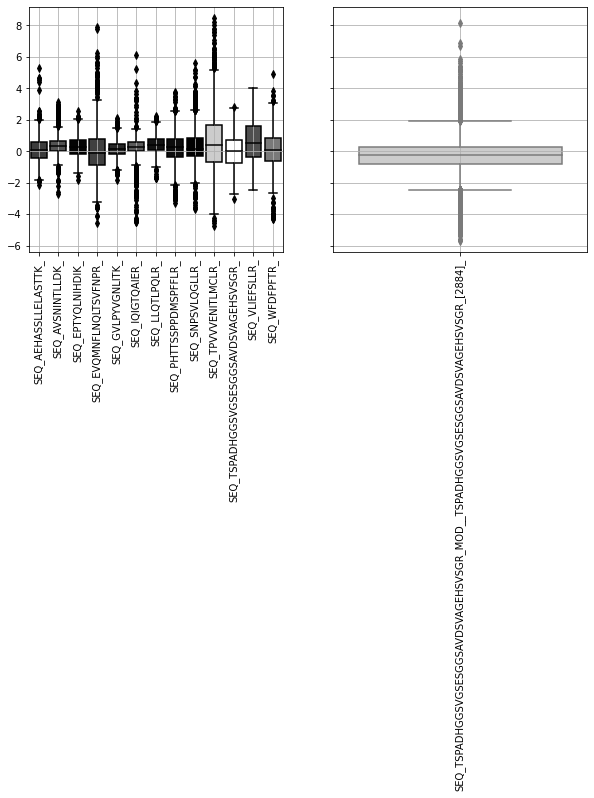

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

def plot_complemented_cluster_condpairinfo(complemented_cluster,clusterdiffinfos_list):
    fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, sharex=False,figsize=(10,5))

    plot_peptides_of_protein(complemented_cluster,clusterdiffinfos_list, ax1)
    plot_phospho_peptides(complemented_cluster, ax2)
    plt.subplots_adjust(bottom = 0.2)
    ax1.grid(True)
    ax2.grid(True)
    return fig



def plot_peptides_of_protein(complemented_cluster, clusterdiffinfos_list, ax):
    condpairinfo_to_plot  = filter_relevant_condpairinfo_for_complemented_cluster(clusterdiffinfos_list, complemented_cluster)
    peptides_to_plot = condpairinfo_to_plot.mainclust_peptide_names + [complemented_cluster.outlier_peptide.peptide_sequence]
    melted_plot_df = pepdf_getter.get_melted_ion_intensity_table_peptide_subset(protein=condpairinfo_to_plot.protein_name,peptides_to_plot=peptides_to_plot, specified_level="seq")
    fcplotter = aqplot.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = condpair)
    ax_protein = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_protein


def plot_phospho_peptides(complemented_cluster, ax):
    peptides_to_plot =  [complemented_cluster.modified_peptide.modified_sequence]
    melted_plot_df = pepdf_getter_ptm.get_melted_ion_intensity_table_peptide_subset(protein=complemented_cluster.modified_peptide.protein_name,peptides_to_plot=peptides_to_plot, specified_level="mod_seq")
    fcplotter = aqplot.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = condpair)
    ax_ptm = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_ptm


def filter_relevant_condpairinfo_for_complemented_cluster(clusterdiffinfos_list, complemented_cluster):
    return filter(lambda x : complemented_cluster.outlier_peptide.peptide_sequence in x.outlier_peptide_names ,clusterdiffinfos_list).__next__()



compclusts = aqoutlier.ComplementedClusterFilterer(complemented_clusterloader,filterconfigs).get_filtered_complemented_clusters()

count = 0
for clust in compclusts:
    print(clust.outlier_peptide.peptide_sequence)
    print(f"outlier fc {clust.outlier_peptide.fc}")
    print(f"modified fc {clust.modified_peptide.fc}")
    print("\n")
    print(f"outlier protnormed {clust.outlier_peptide.protnormed_fc}")
    print(f"modified protnormed {clust.modified_peptide.protnormed_fc}")
    fig = plot_complemented_cluster_condpairinfo(clust, clusterdiffinfos_list)
    #fig.show()
    plt.show()
    count+=1
    
